## Poisson equation solver using the relaxation method

In [1]:
# All lengths in mm, E-fields in V/mm
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi
eta0 = 376.730313461    # Ohms
import cProfile

################## Electrode geometries #################################

class CircularElectrode:
    def __init__(self,x0,y0,D,V0,X,Y,innie=True):
        self.x0, self.y0, self.V0 = x0,y0,V0
        self.D = D
        if innie: self.mask = ( ((X-self.x0)**2 + (Y-self.y0)**2) <= self.D**2/4. )   
        else: self.mask = ( ((X-self.x0)**2 + (Y-self.y0)**2) >= self.D**2/4. )   

#electrodes = [ CircularElectrode(0,0,.24425,V0,innie=True), CircularElectrode(0,0,.5625,0,innie=False) ]   # GR900

class RectangularElectrode:
    def __init__(self,x0,y0,w,h,V0,X,Y,innie=True):
        self.x0, self.y0, self.V0 = x0,y0,V0
        self.w,self.h = w,h
        if innie: self.mask = np.logical_and( np.abs(X-self.x0) <= self.w/2., np.abs(Y-self.y0) <= self.h/2. )   
        else: self.mask = np.logical_or( np.abs(X-self.x0) >= self.w/2., np.abs(Y-self.y0) >= self.h/2. )  
        # Note this subtleness between logical_and vs. logical_or for innies vs. outies


################# Calculation routine ########################

def calculate_voltage(electrodes,bits=10,tlshape=(1024,1024),num_iterations=1e3):
    """Calculation of voltage for an electrode configuration"""
    V_electrode = np.zeros(tlshape)
    for electrode in electrodes: V_electrode[electrode.mask] = electrode.V0
    V_mask = sum([electrode.mask for electrode in electrodes])
    V_mask_inv = np.logical_not(V_mask)

    V = V_mask_inv*np.average(V_electrode)   # initialized

    for i in range(4,bits-1):
        step = 2**(bits-i-1)
        for j in range(2**i):    
            V[step:-step, step:-step] = ((V[0:-2*step, step:-step] + V[2*step:, step:-step]) + (V[step:-step,0:-2*step] + V[step:-step, 2*step:]))/4            
            V = V_mask_inv*V + V_mask*V_electrode

    step = 1
    for i in range(int(num_iterations)):
        V[step:-step, step:-step] = ((V[0:-2*step, step:-step] + V[2*step:, step:-step]) + (V[step:-step,0:-2*step] + V[step:-step, 2*step:]))/4
        V = V_mask_inv*V + V_mask*V_electrode
    
    return V
    
def electric_field(V):
    return np.gradient(V,axis=0,edge_order=2), np.gradient(V,axis=1,edge_order=2)

def characteristic_impedance(V):
    Ex,Ey = electric_field(V)
    Z0 = eta0/( np.sum(Ex**2 + Ey**2) )
    return Z0    # Ohms

#### Test problem: coaxial transmission line

In [2]:
size = 50.0             # mm
grid_bits = 10
grid_points = 2**grid_bits

x = np.arange(-size/2.,size/2., 2*size/grid_points)
y = np.arange(-size/2.,size/2., 2*size/grid_points)

X,Y = np.meshgrid(x,y)

outer_conductor = CircularElectrode(0,0,23.03,0,X,Y,innie=False)
inner_conductor = CircularElectrode(0,0,10.00,1,X,Y,innie=True)
electrodes = [outer_conductor, inner_conductor]
cProfile.run("V = calculate_voltage(electrodes,bits=9,tlshape=X.shape)")
print(f"coax line impedance, Z0 = {characteristic_impedance(V):.3} Ohms") 

         23 function calls in 3.101 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    3.099    3.099    3.101    3.101 87398947.py:30(calculate_voltage)
        1    0.000    0.000    0.000    0.000 87398947.py:34(<listcomp>)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(average)
        1    0.000    0.000    3.101    3.101 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 _methods.py:162(_mean)
        1    0.000    0.000    0.000    0.000 _methods.py:66(_count_reduce_items)
        1    0.000    0.000    0.000    0.000 function_base.py:276(_average_dispatcher)
        1    0.000    0.000    0.000    0.000 function_base.py:280(average)
        1    0.000    0.000    3.101    3.101 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {built-in method builtins.hasattr}
        1    0.000    0.000    0.000    0.000 {built-in method builtins

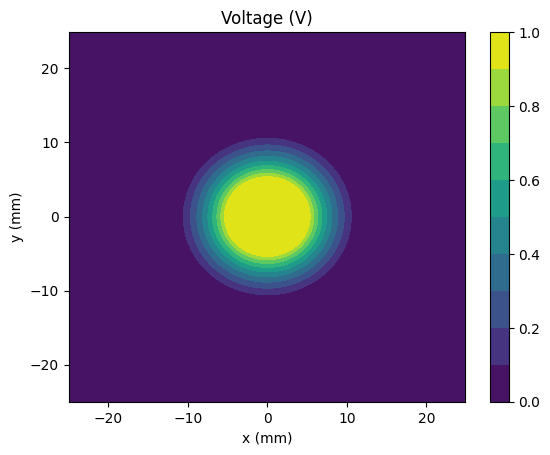

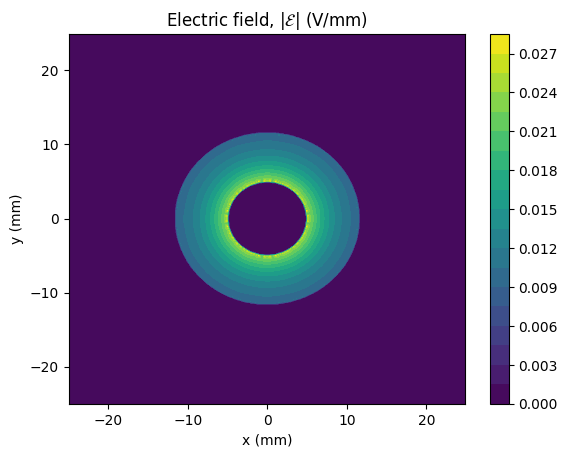

In [3]:
# Plots
plt.figure()
plt.title(r"Voltage (V)")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
C1 = plt.contourf(X,Y,V,10)
plt.colorbar(C1)
plt.show()

# Electric field meshgrid
Ex,Ey = electric_field(V)
E = np.sqrt( Ex**2 + Ey**2 )

plt.figure()
plt.title(r"Electric field, $|\mathcal{E}|$ (V/mm)")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
C2 = plt.contourf(X,Y,E,20)
plt.colorbar(C2)